In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype, Normalize

from matplotlib import pyplot as plt
import numpy as np
import time

In [2]:
print(torch.cuda.is_available(), torch.cuda.get_device_name())

True NVIDIA GeForce RTX 4060


In [3]:
transforms = transforms.Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
trainD = datasets.CIFAR10(root="data", train=True, transform=transforms, download=True)
testD = datasets.CIFAR10(root="data", train=False, transform=transforms, download=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6784315].


5 torch.Size([3, 32, 32]) <class 'torchvision.tv_tensors._image.Image'>


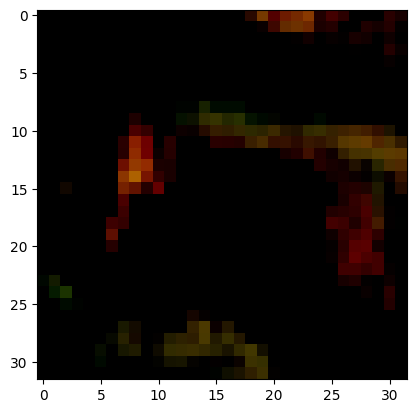

In [5]:
x, label = trainD[np.random.randint(len(trainD))] # 32x32 PIL image, label
plt.imshow(x.permute(1, 2, 0))
print(label, x.size(), type(x))

In [6]:
BATCH_SIZE = 256
DEVICE = torch.accelerator.current_accelerator()

trainDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
testDL = DataLoader(testD, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [7]:
class Cifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.labels = {
                    0: "airplane",  
                    1: "automobile", 
                    2: "bird",
                    3: "cat",
                    4: "deer",
                    5: "dog",
                    6: "frog",
                    7: "horse",
                    8: "ship",
                    9: "truck"
                  }
    self.model = nn.Sequential(
      nn.Conv2d(3, 32, 3, padding=1), # 32x32x32
      nn.ReLU(),

      nn.Conv2d(32, 64, 3), # 29x29x64
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 14x14x64

      nn.Conv2d(64, 128, 3, padding=1), # 14x14x128
      nn.ReLU(),

      nn.Conv2d(128, 216, 5), # 10x10x216 
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 5x5x216

      nn.Flatten(),
      nn.Linear(5*5*216, 512),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Linear(512, 10)
    )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [8]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for batch_i, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    # get predictions
    preds = model(X)
    # calculate loss
    loss = loss_fn(preds, y)
    # backprop
    loss.backward()
    # gradient descent 
    optimizer.step()    
    optimizer.zero_grad()

    if (batch_i % 50 < 1) or (batch_i == len(dataloader) - 1):
      print(f"Batch {batch_i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")


def test(dataloader, model, loss_fn):
  model.eval()
  loss_t = correct = 0
  size, num_batches = len(dataloader.dataset), len(dataloader)
  
  # run through testing data
  with torch.no_grad():
    for batch_i, (X, y) in enumerate(dataloader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      # get model preds
      preds = model(X)
      loss_t += loss_fn(preds, y).item()
      correct += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    
  # calculate average loss & accuracy
  avg_loss = loss_t / num_batches  
  accuracy = correct / size * 100

  print(f"TEST, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

  return accuracy, avg_loss
  

def fit(model, epochs: int):

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
  loss_fn = torch.nn.CrossEntropyLoss()

  accuracies, losses = [], []

  print("Starting...")
  for epoch in range(epochs):
    print("\nEpoch", epoch+1)

    train(trainDL, model, loss_fn, optimizer)
    acc, loss = test(testDL, model, loss_fn )

    accuracies.append(acc)
    losses.append(loss)

  torch.save(model.state_dict(), "model_weights.pth")
  print("Done!\n Weights saved to 'model_weights.pth'")
  return accuracies, losses


In [9]:
EPOCHS = 15
model = Cifar().to(DEVICE)

acc, loss = fit(model, EPOCHS)


Starting...

Epoch 1
Batch 1/196, Loss: 2.3033
Batch 51/196, Loss: 1.7964
Batch 101/196, Loss: 1.5058
Batch 151/196, Loss: 1.4348
Batch 196/196, Loss: 1.5148
TEST, Accuracy: 49.51%, Loss: 1.3774

Epoch 2
Batch 1/196, Loss: 1.3744
Batch 51/196, Loss: 1.2710
Batch 101/196, Loss: 1.4259
Batch 151/196, Loss: 1.4852
Batch 196/196, Loss: 1.3731
TEST, Accuracy: 56.79%, Loss: 1.2004

Epoch 3
Batch 1/196, Loss: 1.2423
Batch 51/196, Loss: 1.1540
Batch 101/196, Loss: 1.1223
Batch 151/196, Loss: 1.0386
Batch 196/196, Loss: 1.2690
TEST, Accuracy: 59.83%, Loss: 1.1096

Epoch 4
Batch 1/196, Loss: 1.1923
Batch 51/196, Loss: 1.0484
Batch 101/196, Loss: 0.9761
Batch 151/196, Loss: 0.9978
Batch 196/196, Loss: 1.0292
TEST, Accuracy: 64.76%, Loss: 0.9920

Epoch 5
Batch 1/196, Loss: 1.0452
Batch 51/196, Loss: 0.9724
Batch 101/196, Loss: 0.8204
Batch 151/196, Loss: 0.8554
Batch 196/196, Loss: 0.9488
TEST, Accuracy: 68.33%, Loss: 0.8974

Epoch 6
Batch 1/196, Loss: 0.8592
Batch 51/196, Loss: 0.8166
Batch 101/1

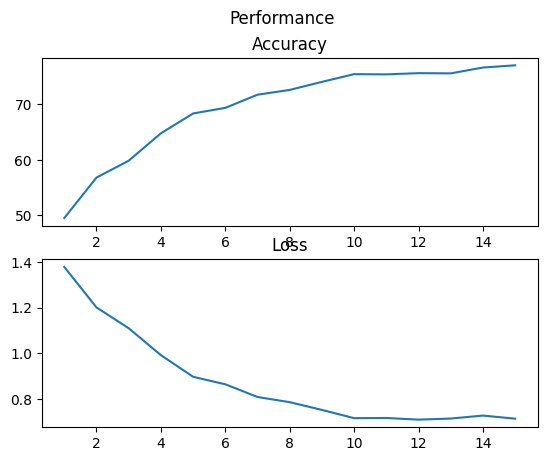

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("Performance")

epochs = range(1, EPOCHS+1)

ax1.plot(epochs, acc)
ax1.set_title("Accuracy")

ax2.plot(epochs, loss)
ax2.set_title("Loss")
plt.savefig(f"performance_{int(time.time())}")

In [11]:
def predict(model):
  model.eval()

  X, label = testD[np.random.randint(len(testD))] # 32x32 PIL image, label
  plt.imshow(X.permute(1, 2, 0))
  X = X.unsqueeze(0).to(DEVICE)
  
  with torch.no_grad():
    pred = model(X).argmax(dim=1).item()

  print(f"Prediction: {model.labels[pred]} ({pred}), Truth: {model.labels[label]} ({label})") 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.8901962].


Prediction: ship (8), Truth: ship (8)


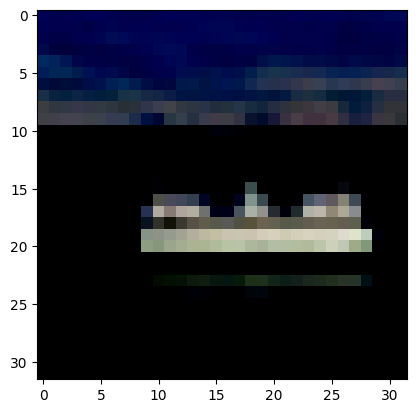

In [12]:
predict(model)